# Notebook for CCI-derived metabolism from scRNA-Seq using MEBOCOST in Fetal Stem Cells and Myelod cells
- **Developed by:** Anna Maguza
- **Place:** Wuerzburg Institute for System Immunology
- **Date:** 20th November 2023

### Import packages

In [2]:
import os,sys
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from mebocost import mebocost

### Set up the cells

In [3]:
%matplotlib inline

In [4]:
sc.settings.verbosity = 3
sc.logging.print_versions()

sc.settings.set_figure_params(frameon=False, dpi=100)

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.9.2
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         10.1.0
adjustText                  NA
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      1.1.0
certifi                     2023.07.22
cffi         

In [5]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

In [6]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Data Upload

In [7]:
input_path = '/home/amaguza/data/Processed_data/Gut_data/Fetal_stem_cells/FetalSC_and_other_fetal_cells/FetalSC_and_myeloid_cells_raw.h5ad'
adata = sc.read_h5ad(input_path)

In [8]:
# Extract the raw counts
adata = adata.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 14997 × 26442
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels'
    var: 'feature_types-0-0-0', 'gene_name-1-0-0', 'gene_id-0-0', 'GENE-1-0'

In [9]:
X_is_raw(adata)

True

In [10]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e6)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Infer metabolic communications

* The mebocost.conf file needs to be provided. It is in the original repo and after installation it will have the correct paths and should work out of the box. You could provide the full path to the file, or create a symlink.

In [11]:
mebo_obj = mebocost.create_obj(
                        adata = adata,
                        group_col = ['Cell States'],
                        met_est = 'mebocost',
                        config_path = '/home/amaguza/MEBOCOST/mebocost.conf',
                        exp_mat = None,
                        cell_ann = None,
                        species = 'human',
                        met_pred = None,
                        met_enzyme = None,
                        met_sensor = None,
                        met_ann = None,
                        scFEA_ann = None,
                        compass_met_ann = None,
                        compass_rxn_ann = None,
                        gene_network = None,
                        gmt_path = None,
                        cutoff_exp = 'auto', ## automated cutoff to exclude lowly ranked 25% sensors across all cells
                        cutoff_met = 'auto', ## automated cutoff to exclude lowly ranked 25% metabolites across all cells
                        cutoff_prop = 0.25, ## at lease 25% of cells should be expressed the sensor or present the metabolite in the cell group (specified by group_col)
                        sensor_type = ['Receptor', 'Transporter', 'Nuclear Receptor'],
                        thread = 4
                        )

[November 20, 2023 18:19:58]: We get expression data with 26442 genes and 14997 cells.
[November 20, 2023 18:19:58]: Data Preparation Done in 0.0669 seconds


### Estimate metabolite presence

* If you just want the table of metabolic activity, you can stop here and export it as a CSV file.

In [12]:
mebo_obj._load_config_()
mebo_obj.estimator()

[November 20, 2023 18:20:01]: Load config and read data based on given species [human].
[November 20, 2023 18:20:02]: Estimtate metabolite level using mebocost


In [13]:
met_mat = pd.DataFrame(mebo_obj.met_mat.toarray(),
                      index = mebo_obj.met_mat_indexer,
                      columns = mebo_obj.met_mat_columns)
met_mat.head()

,AAACCTGCATCTACGA-1-Human_colon_16S8159182,AAACCTGGTGAAAGAG-1-Human_colon_16S8159182,AAACGGGAGACACGAC-1-Human_colon_16S8159182,AAACGGGTCGGCGCAT-1-Human_colon_16S8159182,AAACGGGTCTTACCGC-1-Human_colon_16S8159182,AAAGATGAGATATACG-1-Human_colon_16S8159182,AAAGATGGTCTCCATC-1-Human_colon_16S8159182,AAAGATGTCACCTTAT-1-Human_colon_16S8159182,AAAGCAAGTACCGAGA-1-Human_colon_16S8159182,AAAGCAAGTGACCAAG-1-Human_colon_16S8159182,...,GGCAATTGTCATGCCG-1-4918STDY7718977,GTGCTTCTCAGCATGT-1-4918STDY7718977,GTTTCTAGTCGTGGCT-1-4918STDY7718977,TATTACCAGTGGGTTG-1-4918STDY7718977,TCAGCAAAGTGCGATG-1-4918STDY7718977,TGAGGGATCGGTGTTA-1-4918STDY7718977,TGTCCCAAGTCCCACG-1-4918STDY7718977,TTAGGACCAAGAGGCT-1-4918STDY7718977,TTATGCTTCACTTATC-1-4918STDY7718977,TTGACTTTCGTCGTTC-1-4918STDY7718977
HMDB0003450,0.000000,0.000000,0.000000,0.000000,2.198213,0.000000,2.200197,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
HMDB0003948,1.755592,0.743829,0.000000,0.677888,2.506251,1.641982,1.358103,0.628615,0.0,2.028632,...,1.198334,1.075740,0.605438,0.649066,0.715931,0.723036,1.740266,0.000000,1.325614,0.0
HMDB0003712,1.404473,0.595063,0.524797,0.542310,2.444643,2.071628,1.526522,0.502892,0.0,2.394315,...,0.958667,0.860592,0.968700,0.519253,0.572745,0.578428,1.774494,0.000000,1.590613,0.0
HMDB0003945,2.055245,0.661181,0.583107,0.602567,2.227778,1.880674,1.207203,0.558769,0.0,2.269467,...,1.597778,0.956213,0.538167,0.576948,1.349602,0.642698,2.092097,0.600246,1.690884,0.0
HMDB0003949,1.755592,0.743829,0.000000,0.677888,2.506251,1.641982,1.358103,0.628615,0.0,2.028632,...,1.198334,1.075740,0.605438,0.649066,0.715931,0.723036,1.740266,0.000000,1.325614,0.0


### MEBOCOST cell-cell communication inference

In [14]:
commu_res = mebo_obj.infer_commu(
                                n_shuffle = 1000,
                                seed = 1712, 
                                Return = True, 
                                thread = 4,
                                save_permuation = False,
                                min_cell_number = 3
                            )

[November 20, 2023 18:20:41]: Load config and read data based on given species [human].
[November 20, 2023 18:20:43]: Estimtate metabolite level using mebocost
[November 20, 2023 18:20:50]: Infer communications
[November 20, 2023 18:20:50]: Sensor type used ['Transporter', 'Receptor', 'Nuclear Receptor']
[November 20, 2023 18:20:50]: Parameters: {shuffling: 1000 times, random seed: 1712, thread: 4}
[November 20, 2023 18:20:52]: met_sensor: (350, 8)
[November 20, 2023 18:20:52]: avg_exp: (2166, 15) for (gene, cell) of needed
[November 20, 2023 18:20:52]: avg_met: (592, 15) for (metabolite, cell) of needed
[November 20, 2023 18:20:52]: shuffling 1000 times for generating backgroud
[November 20, 2023 18:20:55]: take exp and met avg for shuffling
[November 20, 2023 18:21:04]: thread: 4
[November 20, 2023 18:21:05]: ABCA1 ~ HMDB0006247
[November 20, 2023 18:21:05]: Normalizing Cluster Mean and Calculating Communication Score
[November 20, 2023 18:21:05]: Calculating P-value
[November 20, 20

In [15]:
print('sensor_exp cutoff: %s'%mebo_obj.cutoff_exp)
print('metabolite_presence cutoff: %s'%mebo_obj.cutoff_met)

sensor_exp cutoff: 4.384387493133545
metabolite_presence cutoff: 0.7798576354980469


In [16]:
# Save results
commu_res.to_csv('/home/amaguza/data/Processed_data/Gut_data/Fetal_stem_cells/FetalSC_and_other_fetal_cells/FetalSC_and_myeloid_mebocost_results.csv')

### Visualise MEBOCOST prediction

### Showing the detailed communications (sender-receiver vs metabolite-sensor) in a dot map

In [17]:
adata.obs['Cell States'].value_counts()

ASS1+_SLC40A1+_SC                3979
RPS10+_RPS17+_SC                 3544
Macrophages                      3105
LYVE1+ Macrophage                1757
cDC2                             1232
Monocytes                         439
FXYD3+_CKB+_SC                    294
cDC1                              210
CLC+ Mast cell                    121
MPO+ mono-neutrophil              114
pDC                               102
Megakaryocyte                      56
Mast cell                          31
Lymphoid DC                         9
MMP9+ Inflammatory macrophage       4
Name: Cell States, dtype: int64

[November 20, 2023 18:23:15]: plot heatmap for significant result


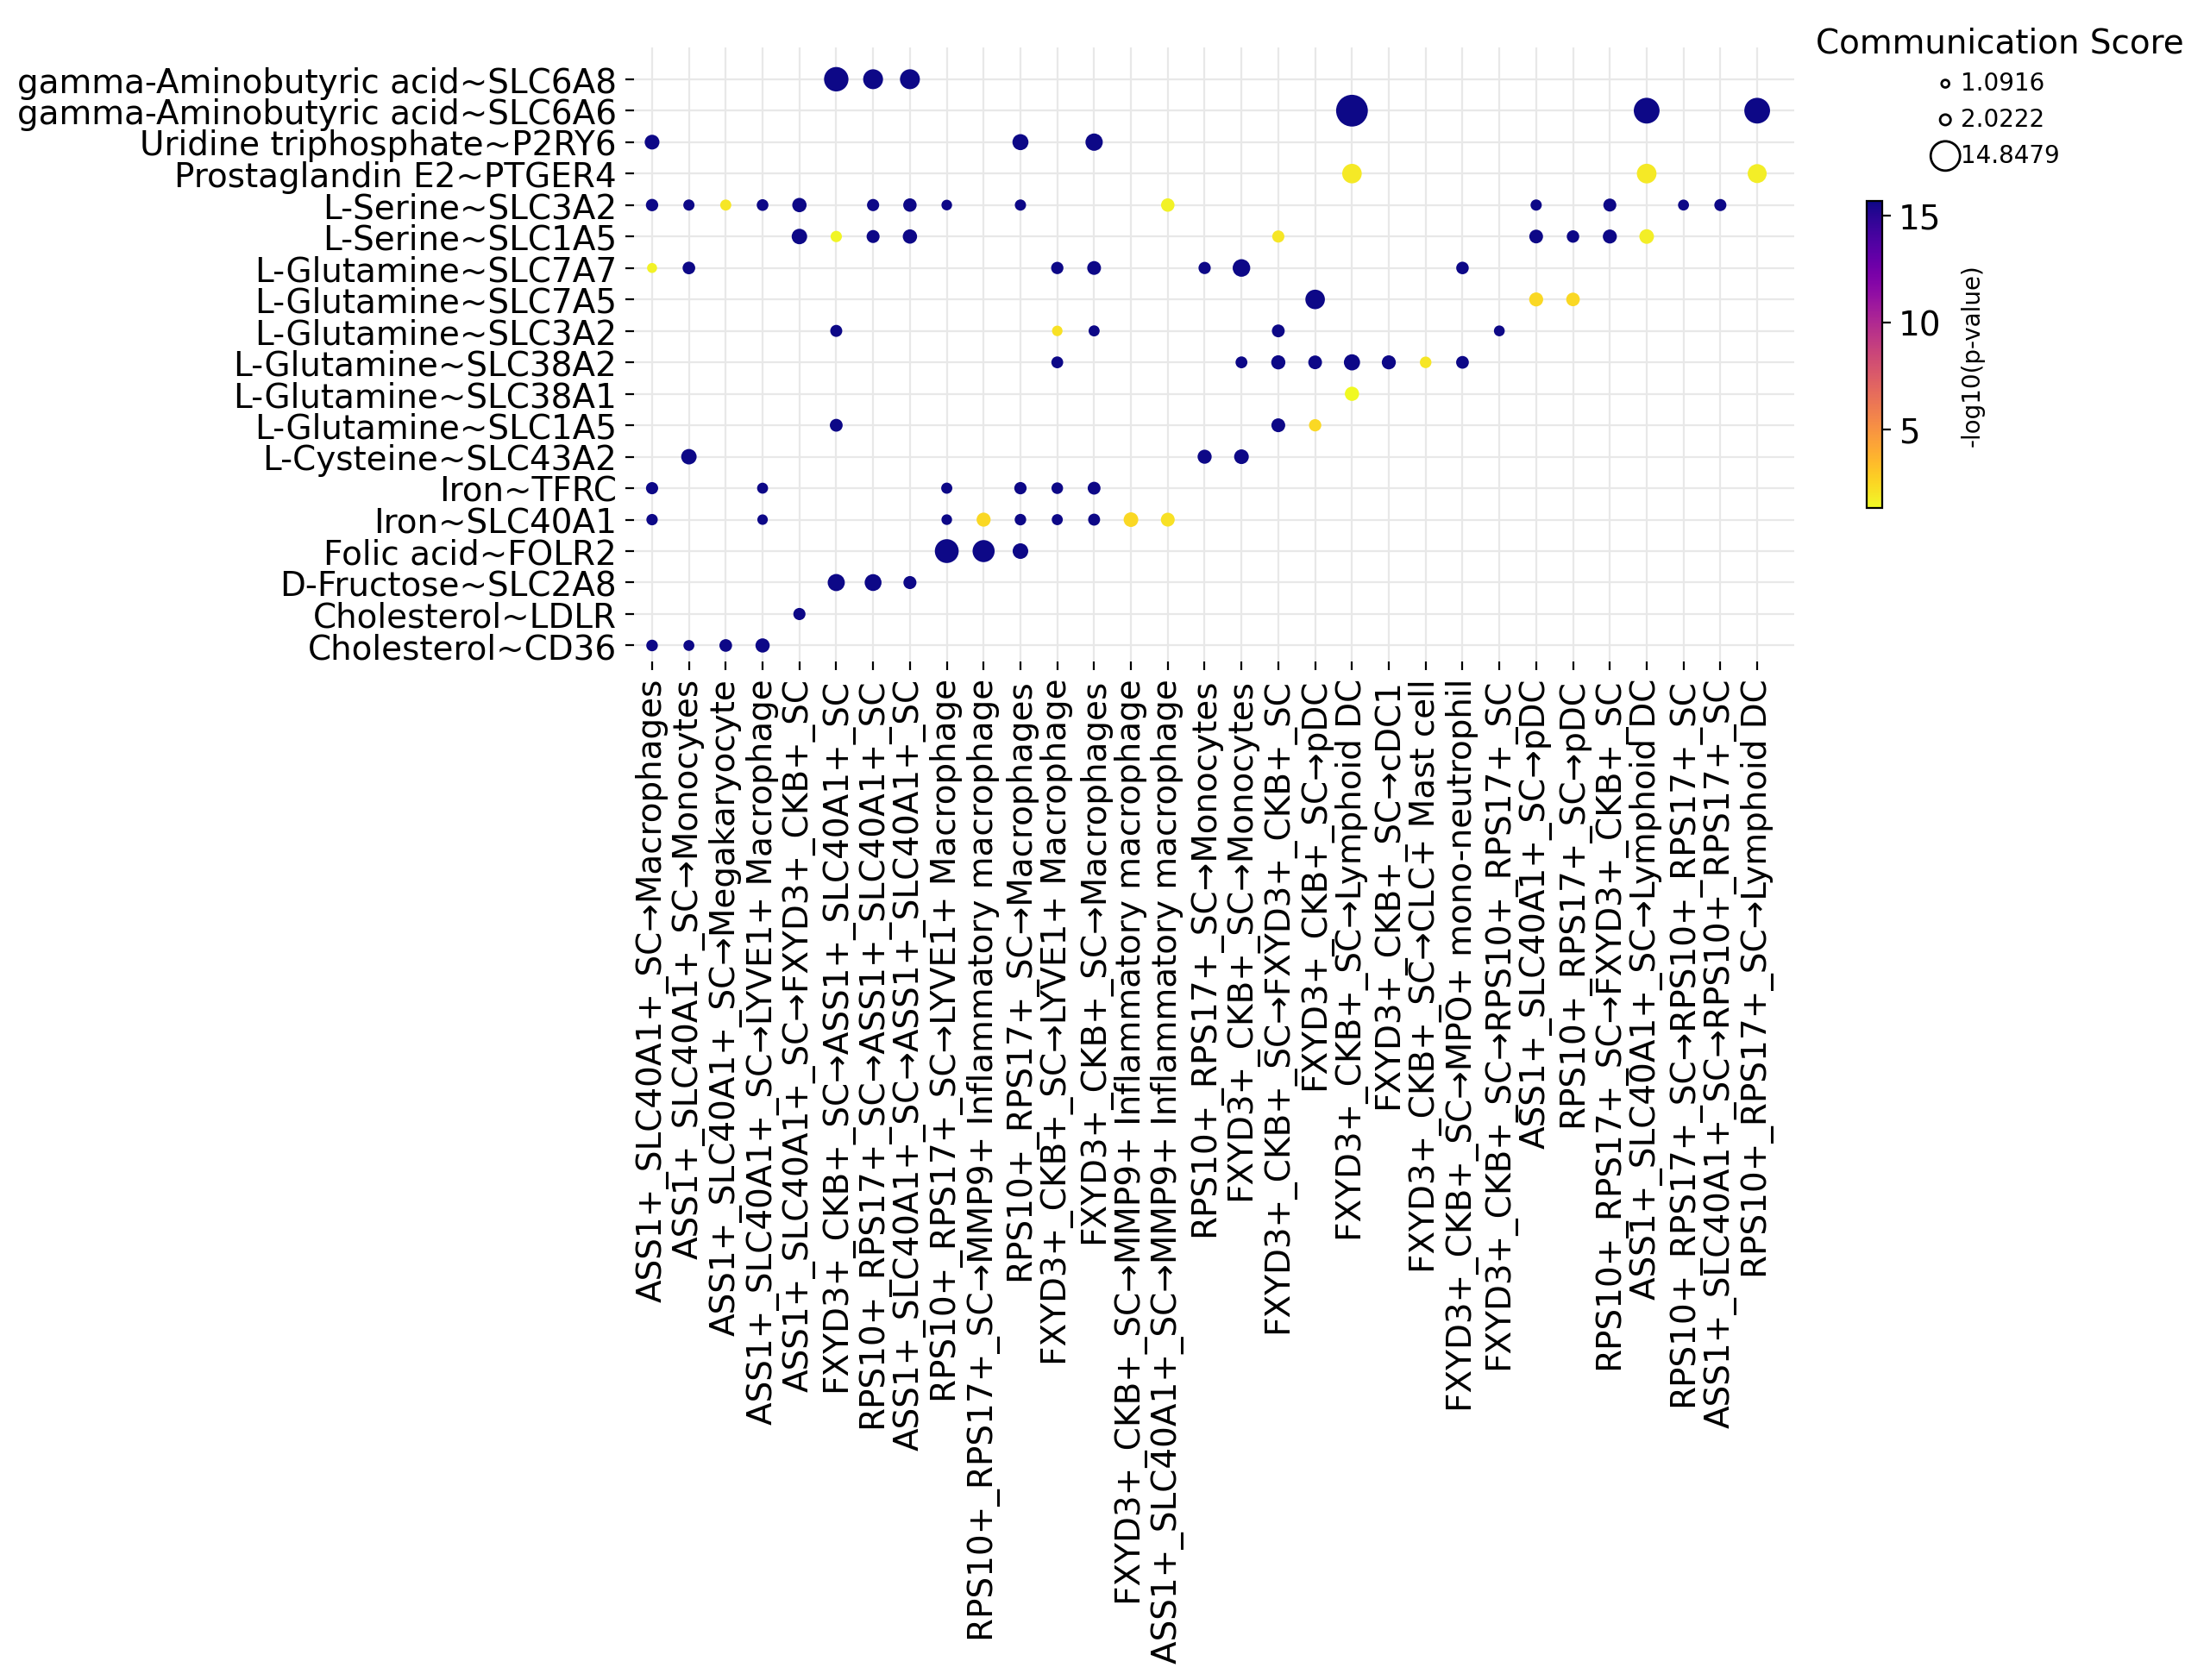

In [18]:
mebo_obj.commu_dotmap(
                sender_focus = ['ASS1+_SLC40A1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC'],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                and_or = 'and',
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                figsize = 'auto',
                cmap = 'plasma_r',
                node_size_norm = (10, 150),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                swap_axis = False,
                return_fig = False
                )

[November 20, 2023 18:23:16]: plot heatmap for significant result


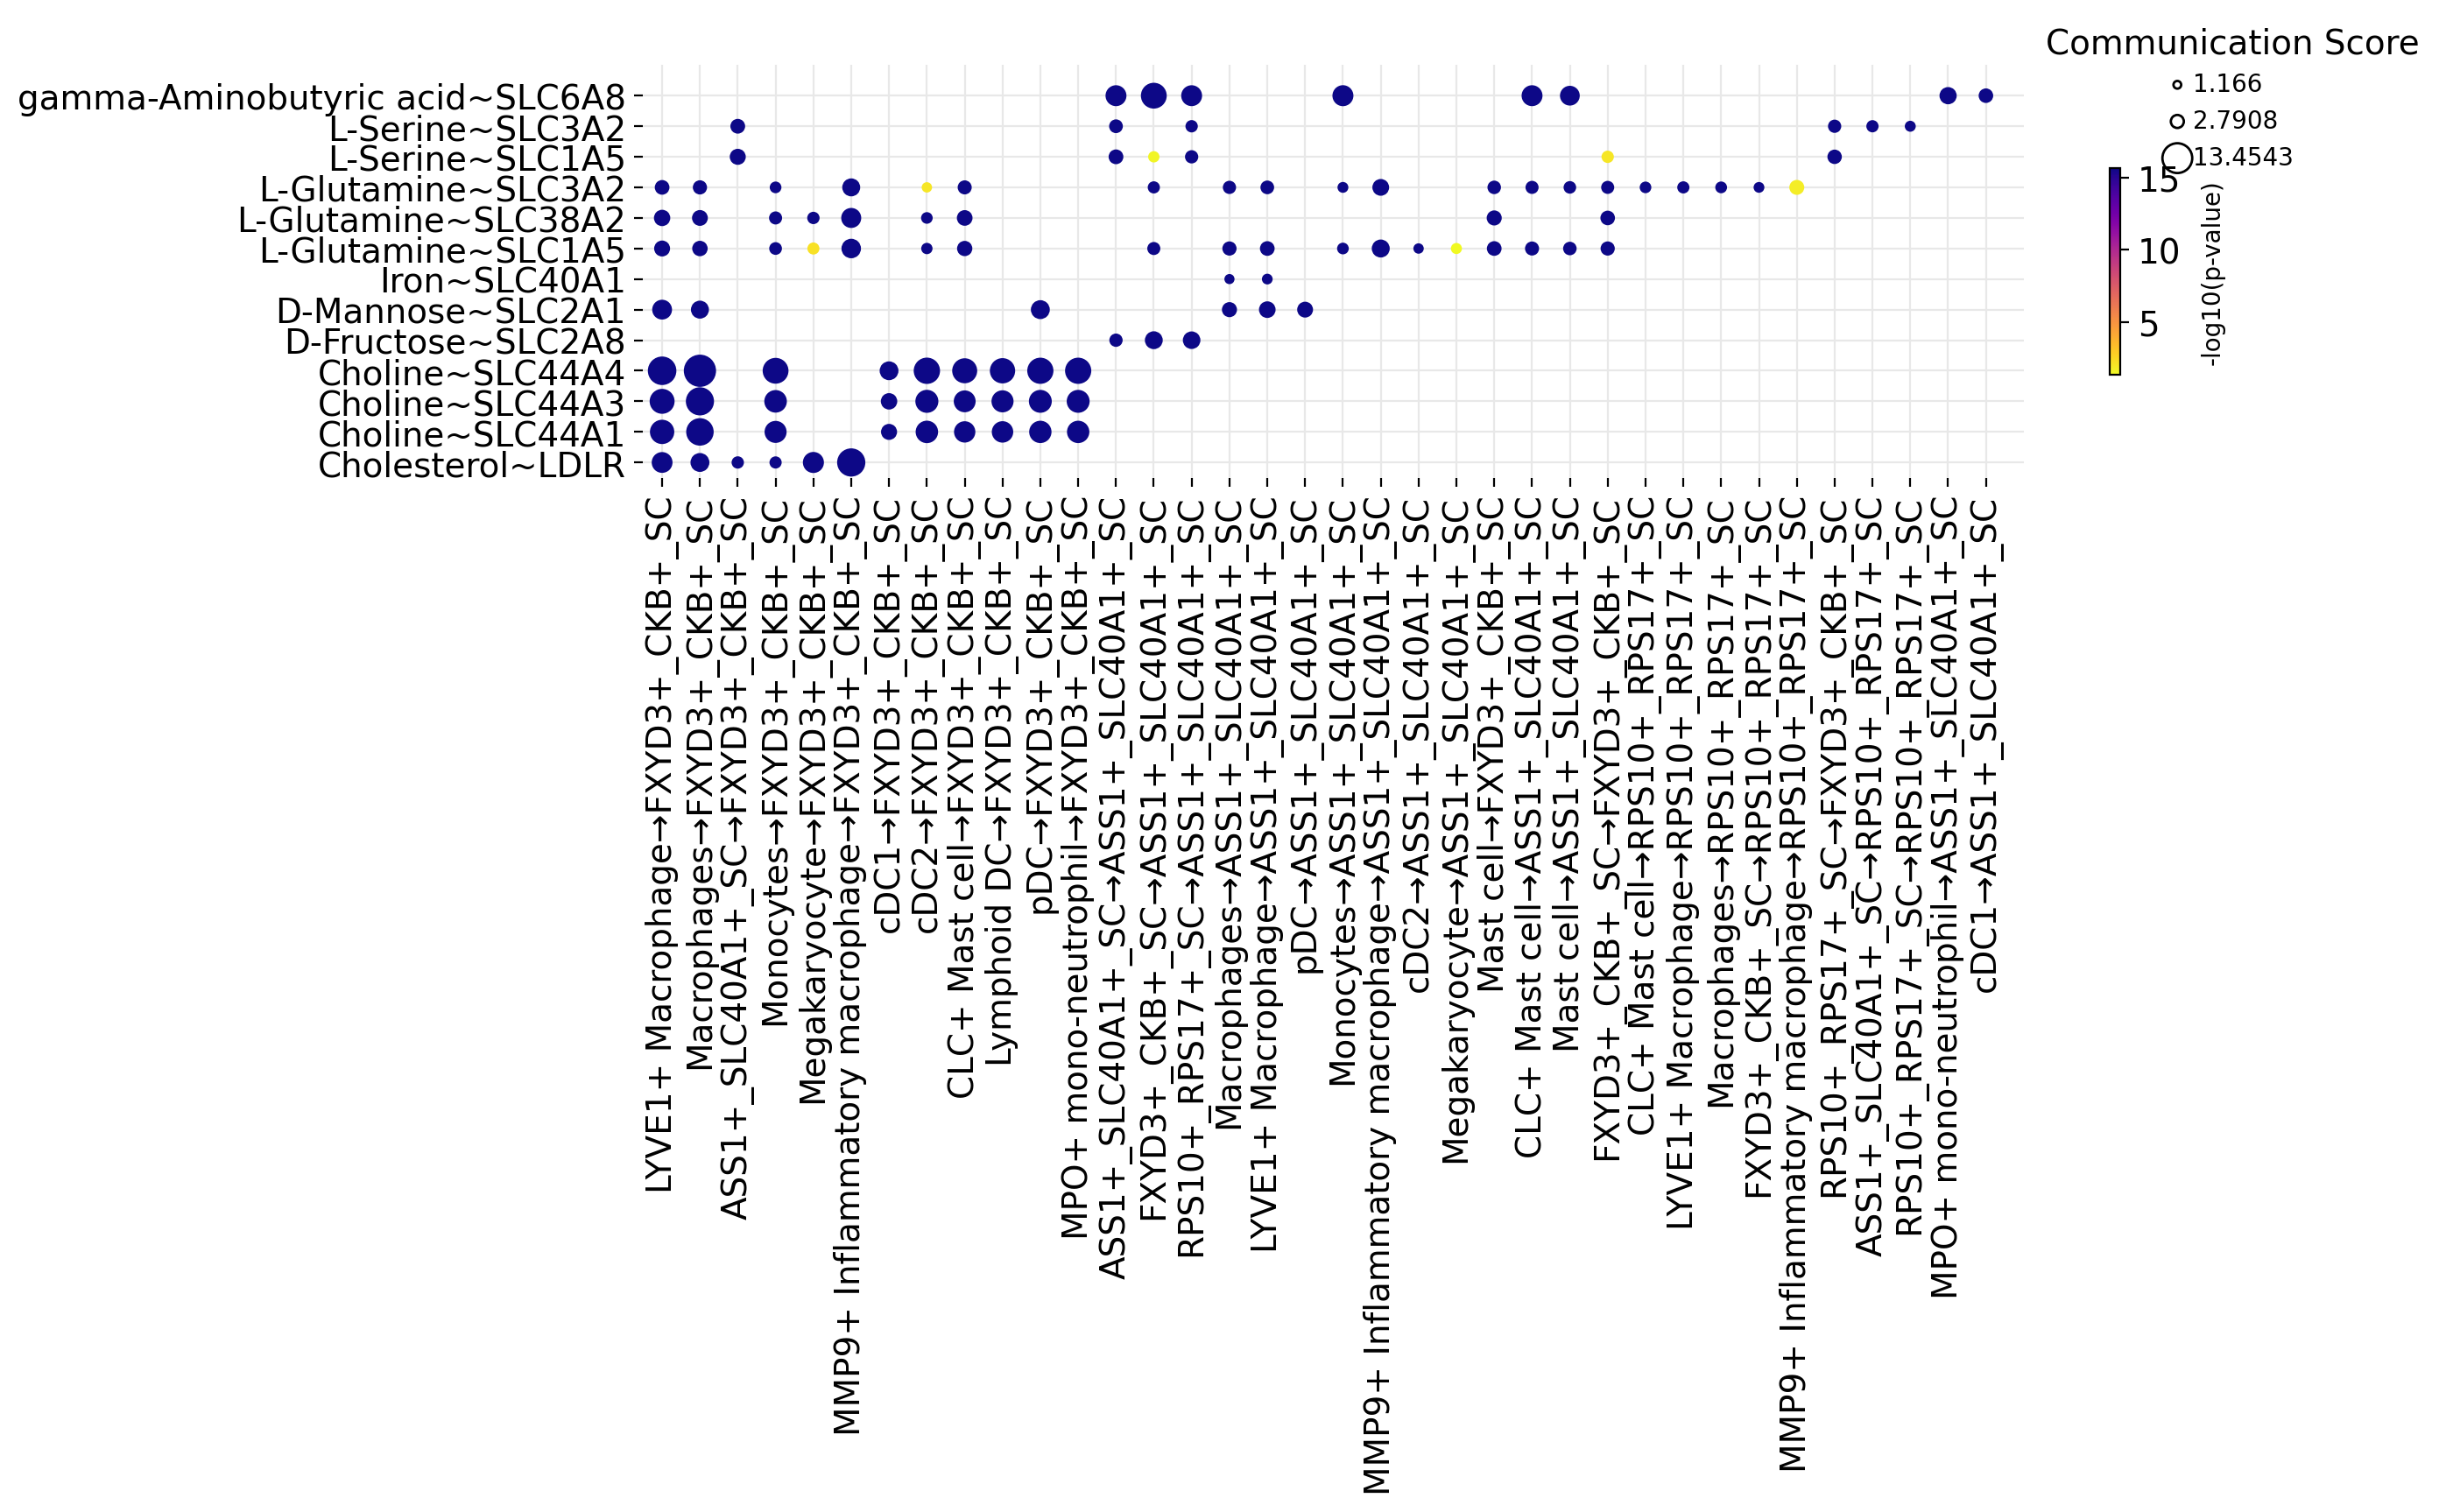

In [19]:
mebo_obj.commu_dotmap(
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = ['ASS1+_SLC40A1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC'],
                and_or = 'and',
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                figsize = 'auto',
                cmap = 'plasma_r',
                node_size_norm = (10, 150),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                swap_axis = False,
                return_fig = False
                )

[November 20, 2023 18:27:09]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


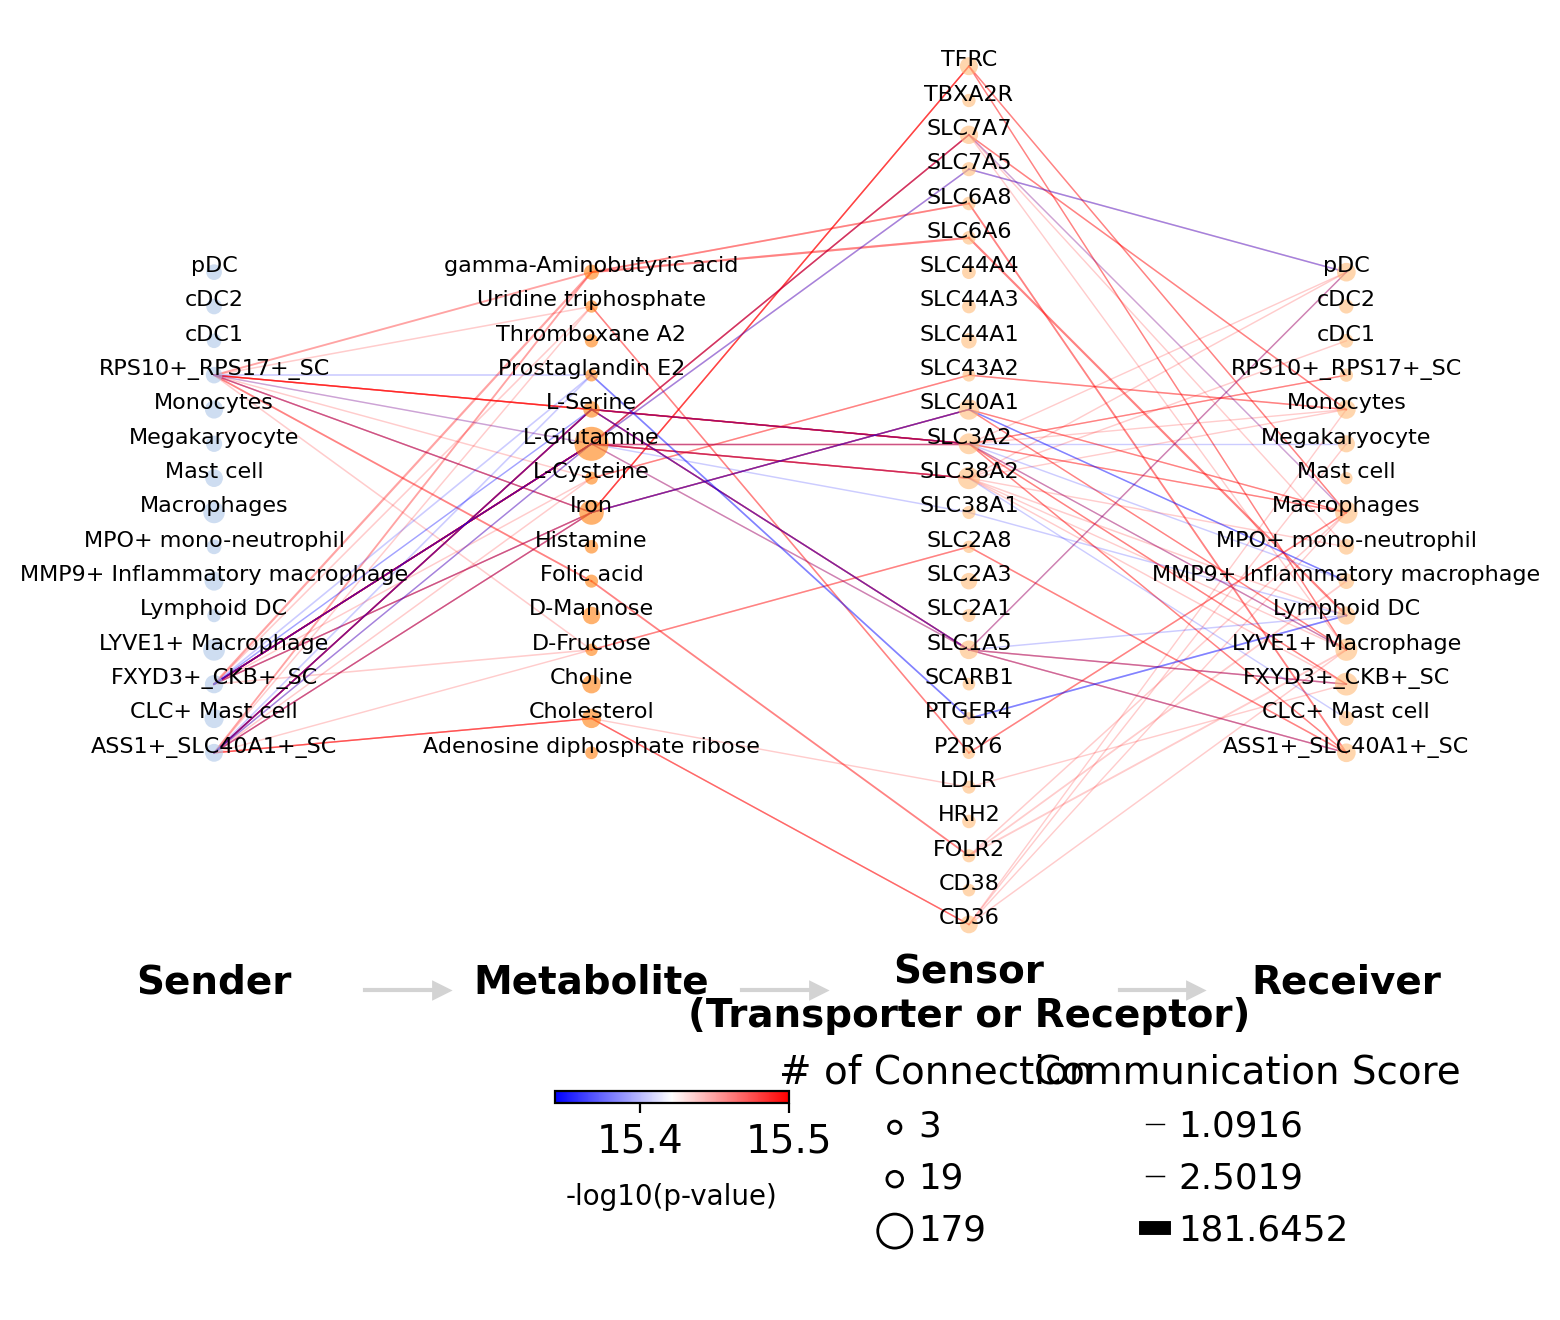

In [20]:
mebo_obj.FlowPlot(
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                sender_focus = ['ASS1+_SLC40A1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC'],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                remove_unrelevant = False,
                and_or = 'and',
                node_label_size = 8,
                node_alpha = 0.6,
                figsize = 'auto',
                node_cmap = 'tab20',
                line_cmap = 'bwr',
                line_vmin = None,
                line_vmax = 15.5,
                node_size_norm = (20, 150),
                linewidth_norm = (0.5, 5),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                text_outline = False,
                return_fig = False
            )

[November 20, 2023 18:27:33]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


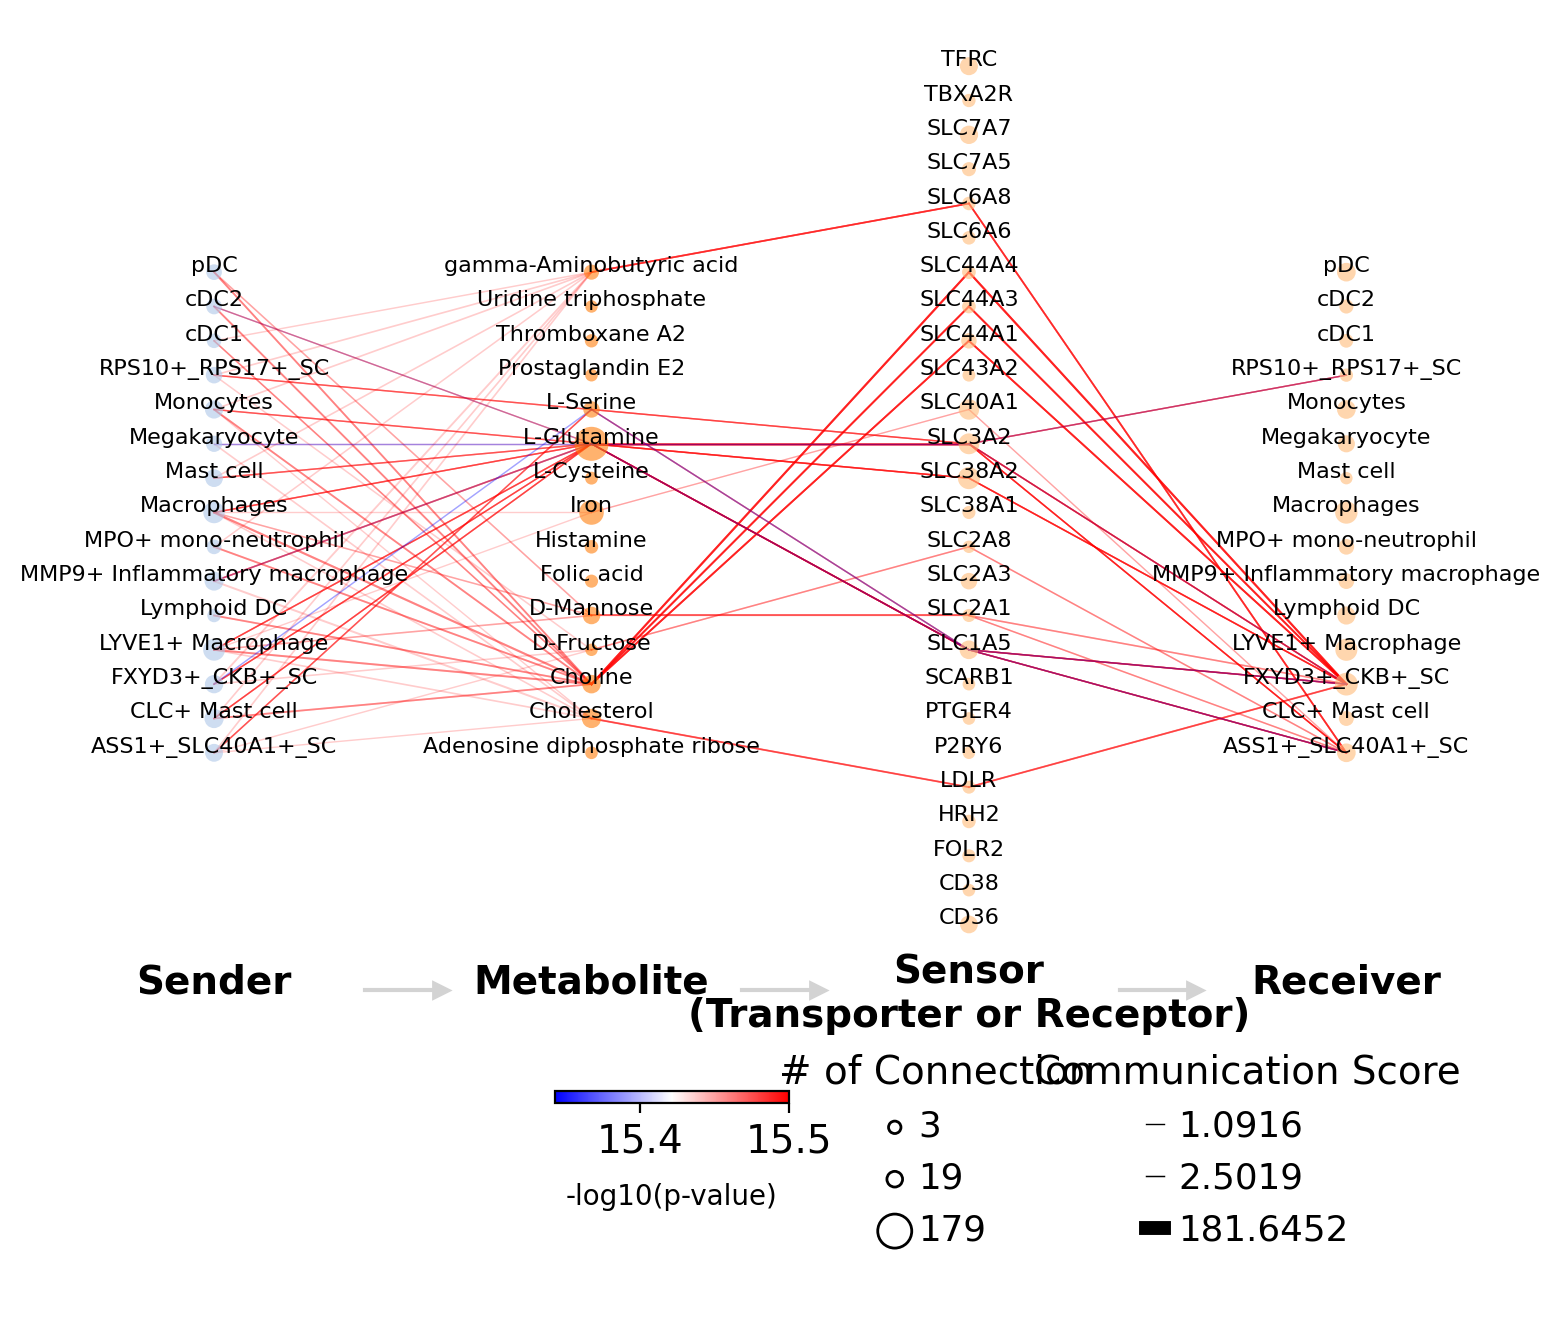

In [21]:
mebo_obj.FlowPlot(
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = ['ASS1+_SLC40A1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC'],
                remove_unrelevant = False,
                and_or = 'and',
                node_label_size = 8,
                node_alpha = 0.6,
                figsize = 'auto',
                node_cmap = 'tab20',
                line_cmap = 'bwr',
                line_vmin = None,
                line_vmax = 15.5,
                node_size_norm = (20, 150),
                linewidth_norm = (0.5, 5),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                text_outline = False,
                return_fig = False
            )

[November 20, 2023 18:27:49]: Warnings: no sensors to plot
[November 20, 2023 18:27:49]: Find metabolites ['Uridine triphosphate', 'L-Cysteine', 'Histamine', 'L-Serine', 'D-Fructose', 'gamma-Aminobutyric acid', 'Thromboxane A2', 'Prostaglandin E2', 'Choline', 'Adenosine diphosphate ribose', 'Cholesterol', 'Folic acid', 'D-Mannose', 'Iron', 'L-Glutamine'] to plot violin


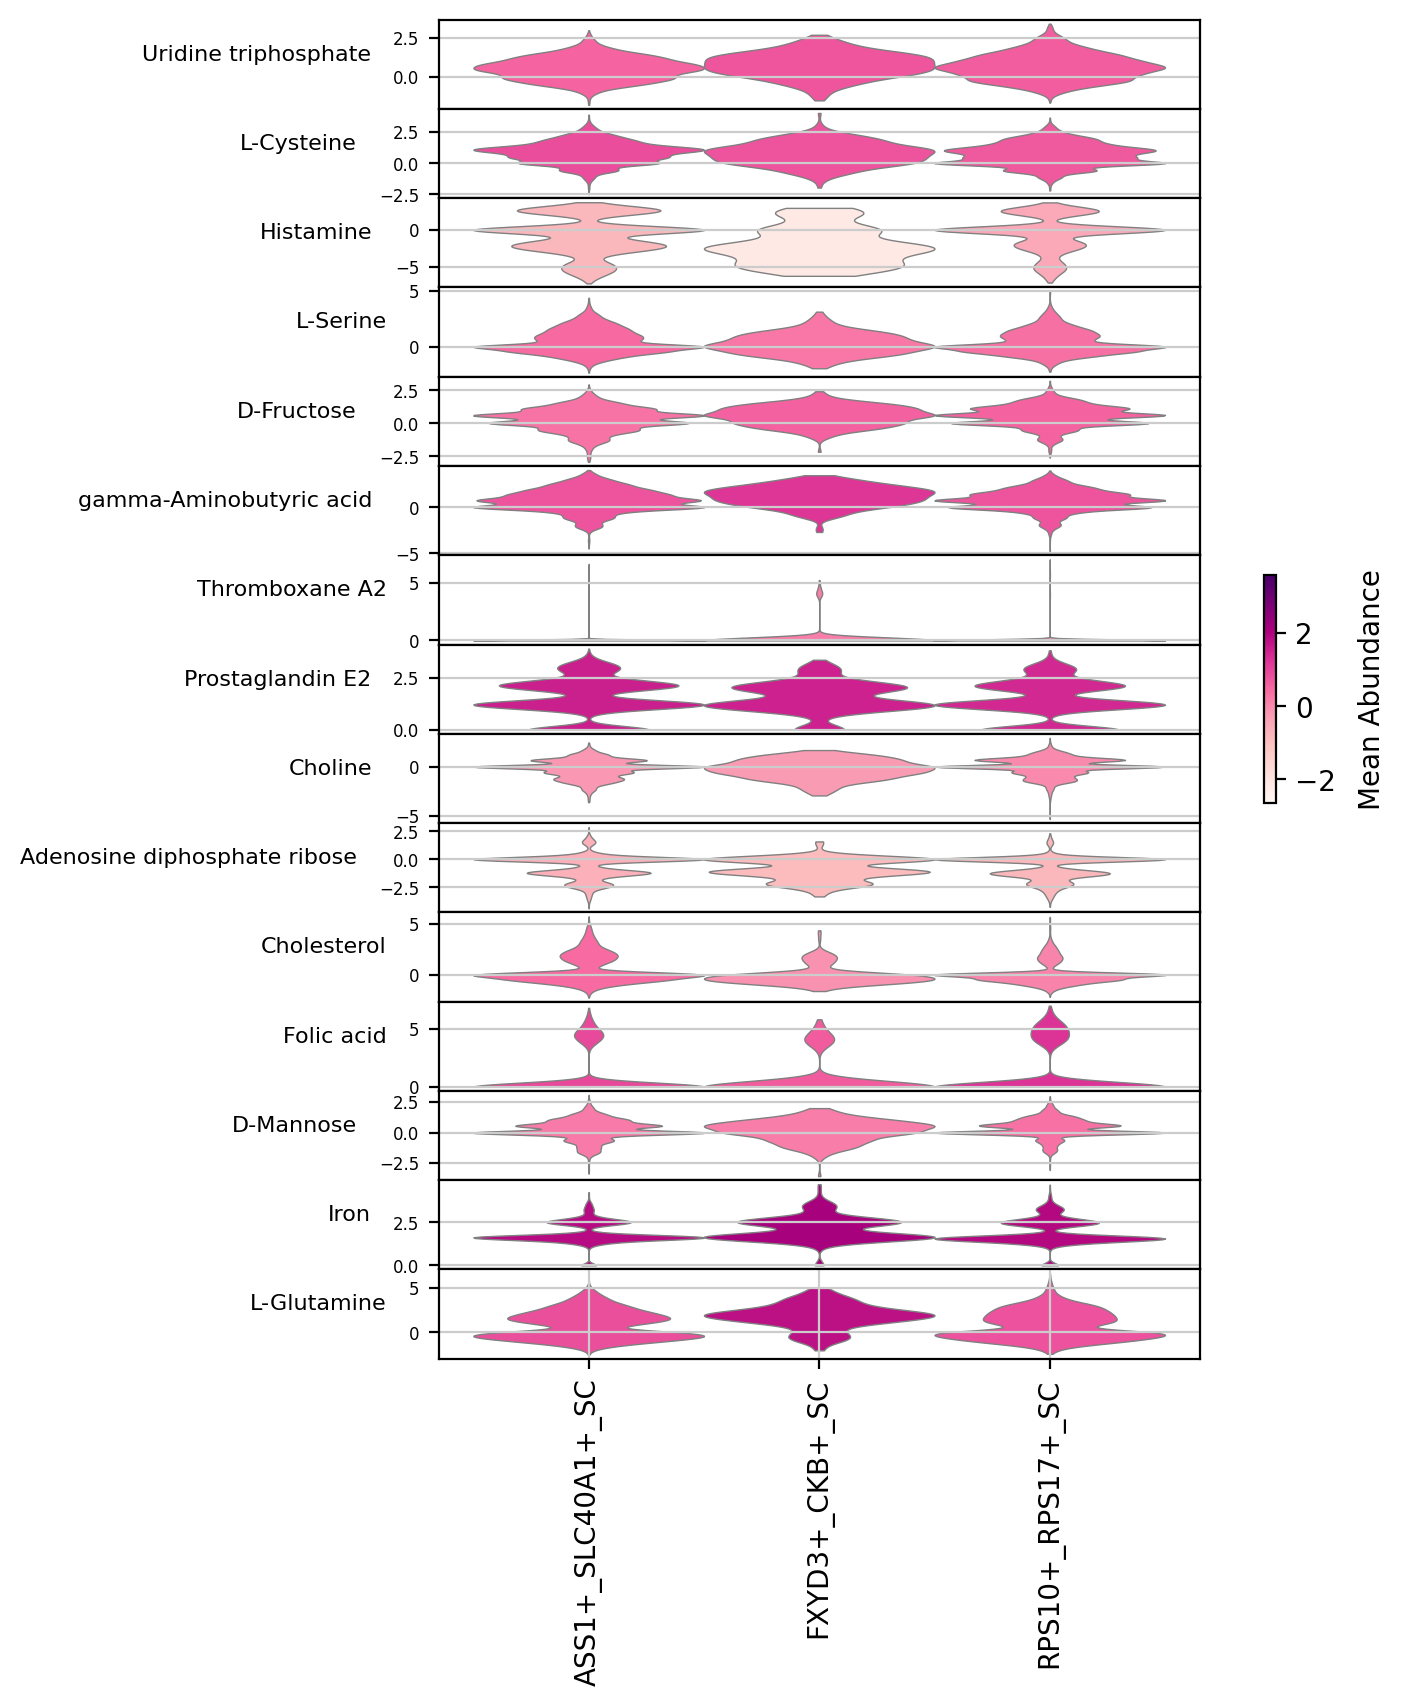

In [22]:
commu_df = mebo_obj.commu_res.copy()
commu_df = mebo_obj.commu_res.copy()
good_met = commu_df[(commu_df['permutation_test_fdr']<=0.05)]['Metabolite_Name'].sort_values().unique()

mebo_obj.violin_plot(
                    sensor_or_met = good_met[:15], ## only top 5 as example
                    cell_focus = ['ASS1+_SLC40A1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC'],
                    cmap = 'RdPu',
                    vmin = None,
                    vmax = None,
                    figsize = 'auto',
                    cbar_title = '',
                    save = None,
                    show_plot = True
                    )